In [2]:
#dataset

In [194]:
import numpy as np
import os
from pathlib import Path

#used for reading images
from keras.preprocessing import image


In [195]:
#define path to data set folder

p=Path('./Images/')

#very useful method of Path class.
#This function accepts a regular expression i.e. for what kind of files i want to look into this path
dirs=p.glob("*")#this is a generator object , we can iterate over all the values in this object/folder such that it will give paths over all the files/folders in it.

labels_dict={"cat":0,"dog":1,"horse":2,"human":3}

image_data=[]
labels=[]

In [196]:
for folder_name in dirs:
    print(folder_name)
    
    #extract labels(for classes) for each folder in dirs
    #str()--> path object is converted into string
    
    #first slash is used beacuase second slah which is for path is special character and in double quoes it loses its meaning
    label = str(folder_name).split("\\")[-1][:-1]
    
    
    #now we need to iterate ins`ide each folder i.e. over folder items
    for img_path in folder_name.glob("*.jpg"):
        #print(img_path)#this is image path
        #read image
        img=image.load_img(img_path,target_size=(32,32))
        
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

Images\cats
Images\dogs
Images\horses
Images\humans


In [197]:
print(len(image_data))
print(len(labels))


808
808


In [198]:
#convert this data into numpy array

image_data=np.array(image_data,dtype="float32")/255.0
labels=np.array(labels)

print(image_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


In [199]:
#random shuffle data
import random

#note we need to zip both image_data and labels together otherwise if we shuffle only image_data and not their labels with them then, there will be mismatch between two
combined=list(zip(image_data,labels))
random.shuffle(combined)

#unzip
image_data[:],labels[:]=zip(*combined)

In [200]:
#visulaise this data.
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return



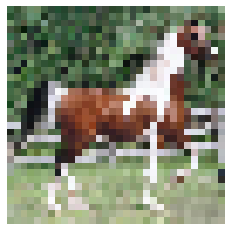

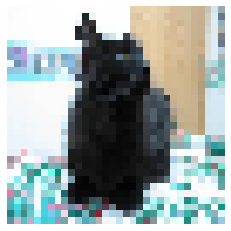

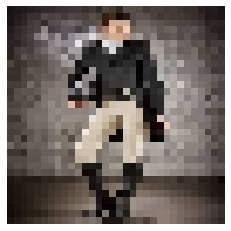

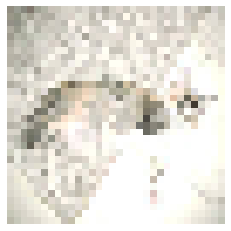

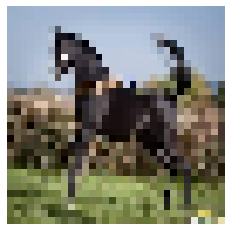

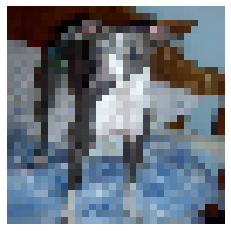

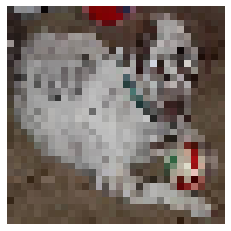

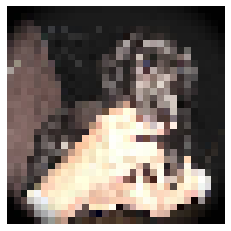

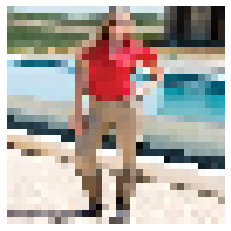

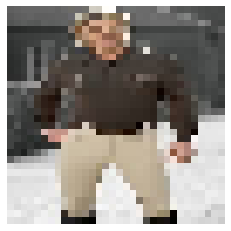

In [201]:
for i in range(10):
    drawImg(image_data[i])

In [45]:
#SVM classifier.
#we will feed this data to SVM


In [202]:
class SVM:
    
    def __init__(self,c=1.0):
        self.C=c
        self.W=0
        self.b=0
    
    def hingeloss(self,W,b,X,Y):
        loss=0.0
        
        loss+=(0.5)*np.dot(W,W.T)
        
        m=X.shape[0]
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+b)# W.(X.T) is done in order to get a scalar number
            loss+=self.C*max(0,(1-ti))
        
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        n=learning_rate
        c=self.C
        
        W=np.zeros((1,no_of_features))
        bias=0
        
#         print("loss in begining")
#         print(self.hingeloss(W,bias,X,Y))
        
        #weight and bias update rule
        losses=[]
        
        for i in range(maxItr):
            l=self.hingeloss(W,bias,X,Y)
            losses.append(l)
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient descent
            for batch_start in range(0,no_of_samples,batch_size):
                #assume 0 gradient for batch.
                grad_wrt_w=0
                grad_wrt_b=0
                
                #iterate over all examples
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            grad_wrt_w+=0
                            grad_wrt_b+=0
                        else:
                            grad_wrt_w+=c*Y[i]*X[i]
                            grad_wrt_b+=c*Y[i]
                            
                #grad for the batch is prepared
                W=W-learning_rate*W + learning_rate*grad_wrt_w
                bias=bias+learning_rate*grad_wrt_b
        
        self.W=W
        self.b=bias
        return W,bias,losses
                
                
                
        

In [47]:
#since it is a binary classifier so we need to convert data for one vs one classifier

In [66]:
#build  a dictionary in which class label will be the key and list of data points belonging to that label as value of key


In [203]:
#flattening every image into single row.

m=image_data.shape[0]
print(image_data.shape)
image_data=image_data.reshape(m,-1)
print(image_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808, 3072)
(808,)


In [204]:
no_of_classes=len(np.unique(labels))
print(no_of_classes)

def classWiseDataDictionary(x,y):
    data={}
    
    for i in range(no_of_classes):
        data[i]=[]
        
    for i in range(m):
            data[y[i]].append(x[i])
    
    #converting everything into numpy array
    for k in data.keys():
        data[k]=np.array(data[k])
    
    return data

4


In [169]:
data=classWiseDataDictionary(image_data,labels)

In [207]:
#it will basically return the count of examples of class 0
print(data[0].shape[0])#it will basically return the count of examples of class 0
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

202
202
202
202


In [86]:
#feed this data to svm

In [208]:
def getDataPairForSVM(d1,d2):
    #notebook for visual understanding
    
    l1,l2=d1.shape[0],d2.shape[0]
    
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    
    data_labels=np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    data_labels[:l1]=-1
    data_labels[l1:]=+1
    
    return data_pair,data_labels
    
    

In [211]:
mySVM=SVM()


def trainSVM(x,y):
    svm_classifiers={}
    
    for i in range(no_of_classes):
        svm_classifiers[i]={}
        for j in range(i+1,no_of_classes):
            xpair,ypair=getDataPairForSVM(data[i],data[j])
            wts,biases,losses=mySVM.fit(xpair,ypair)
            
            svm_classifiers[i][j]=(wts,biases)
    return svm_classifiers

svm_classifiers=trainSVM(image_data,labels)
 
#parameters for cat an dogs
# print(svm_classifiers[0][1])
cats_dogs=svm_classifiers[0][1]
print(cats_dogs[0].shape)#weights
print(cats_dogs[1])#bias
#cats and humans
cats_humans=svm_classifiers[0][3]
print(cats_humans[0].shape)#weights
print(cats_humans[1])#bias

(1, 3072)
-1.1729999999999976
(1, 3072)
-0.8260000000000005


In [212]:
#prediction

def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    
    if z>=0:
        return 1
    else:
        return -1



In [213]:
def predict(x):
    
    count=np.zeros((no_of_classes,))
    for i in range(no_of_classes):
        for j in range(i+1,no_of_classes):
            w,b=svm_classifiers[i][j]
            
            #take majority prediction
            z=binaryPredict(x,w,b)
            
            #beacuse while building the classifiers we labelled d2 as +1 and d1 as -1
            if z==1 :
                count[j]+=1
                
            else:
                count[i]+=1
        
        #print(count)
        return np.argmax(count)

In [219]:
print(predict(image_data[3]))
print(labels[3])

0
0
